<a href="https://colab.research.google.com/github/Sibahle01/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# Brain Tumor Classification - YouTube Tutorial
# Import necessary libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set aesthetic style for plots
plt.style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


📁 Dataset Structure:
Contents of dataset directory: ['yes', 'no']

📊 Dataset Statistics:
Tumor images (yes): 87
Non-tumor images (no): 92
Total images: 179


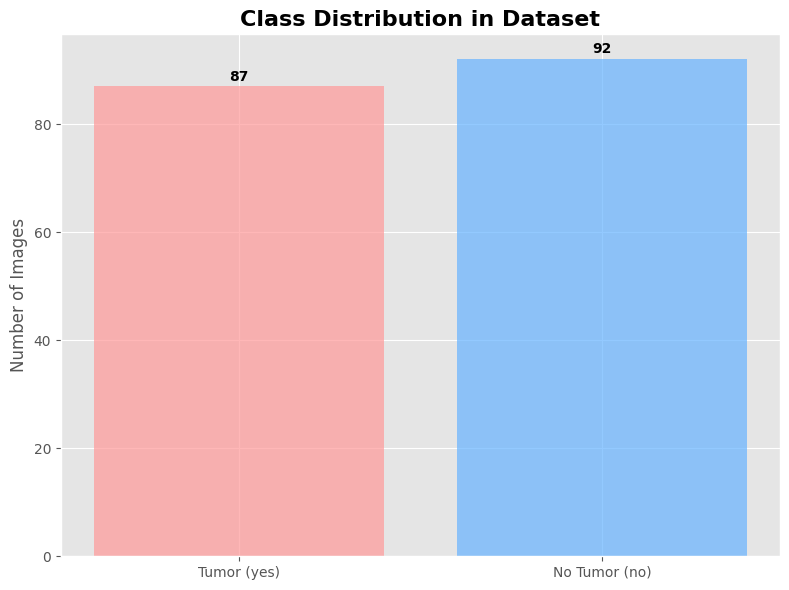

In [42]:
# Dataset path - UPDATE THIS TO YOUR ACTUAL PATH
dataset_dir = "/content/drive/MyDrive/brain_tumor_dataset"

# Check dataset structure
print("📁 Dataset Structure:")
print("Contents of dataset directory:", os.listdir(dataset_dir))

# Count images in each category
yes_dir = os.path.join(dataset_dir, "yes")
no_dir = os.path.join(dataset_dir, "no")

yes_count = len([name for name in os.listdir(yes_dir) if name.endswith(('.jpg', '.jpeg', '.png'))])
no_count = len([name for name in os.listdir(no_dir) if name.endswith(('.jpg', '.jpeg', '.png'))])

print(f"\n📊 Dataset Statistics:")
print(f"Tumor images (yes): {yes_count}")
print(f"Non-tumor images (no): {no_count}")
print(f"Total images: {yes_count + no_count}")

# Visualize class distribution
fig, ax = plt.subplots(figsize=(8, 6))
categories = ['Tumor (yes)', 'No Tumor (no)']
counts = [yes_count, no_count]
colors = ['#ff9999', '#66b3ff']

bars = ax.bar(categories, counts, color=colors, alpha=0.7)
ax.set_title('Class Distribution in Dataset', fontsize=16, fontweight='bold')
ax.set_ylabel('Number of Images', fontsize=12)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

🖼️ Sample Tumor Images:


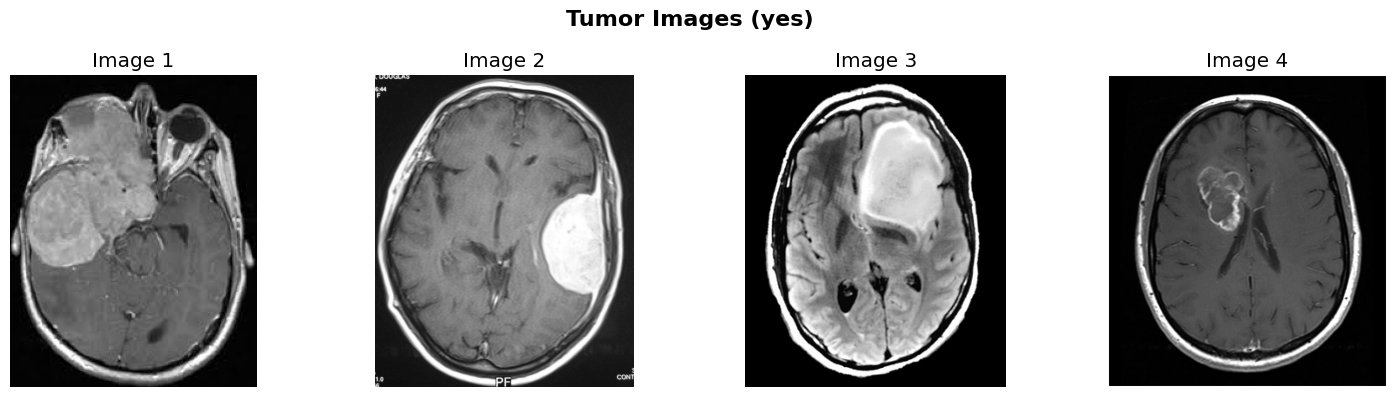


🖼️ Sample Non-Tumor Images:


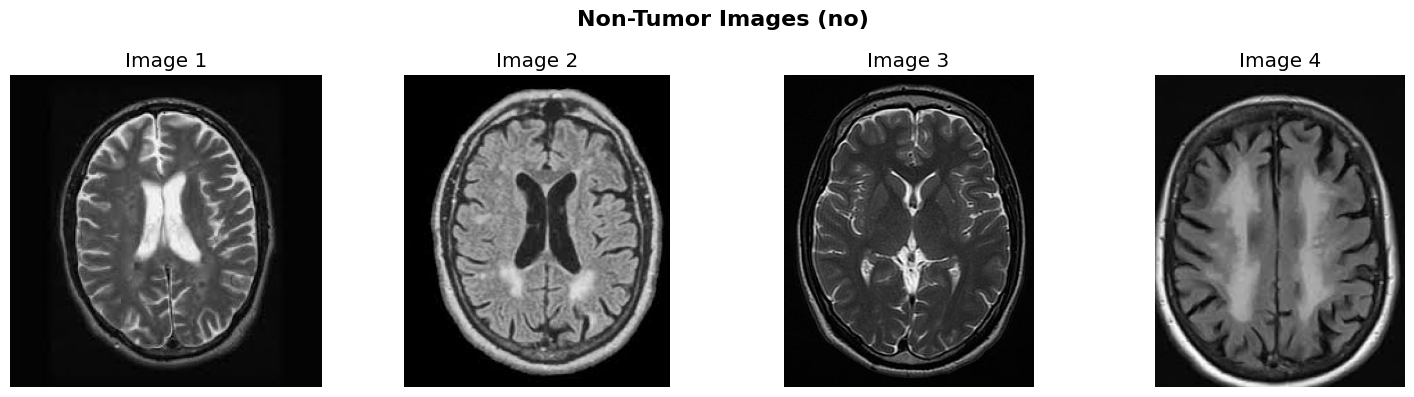

In [43]:
# Display sample images from both classes
def display_sample_images(class_dir, title, num_samples=4):
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    for i, image_file in enumerate(image_files):
        img = plt.imread(os.path.join(class_dir, image_file))
        axes[i].imshow(img, cmap='gray' if len(img.shape) == 2 else None)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("🖼️ Sample Tumor Images:")
display_sample_images(yes_dir, "Tumor Images (yes)")

print("\n🖼️ Sample Non-Tumor Images:")
display_sample_images(no_dir, "Non-Tumor Images (no)")

In [44]:
# Create a structured dataset for training and testing
print("📂 Preparing dataset for training...")

# Create temporary directories
temp_dataset_dir = "/content/brain_tumor_dataset_structured"
if os.path.exists(temp_dataset_dir):
    shutil.rmtree(temp_dataset_dir)

os.makedirs(temp_dataset_dir, exist_ok=True)
train_dir = os.path.join(temp_dataset_dir, "Training")
test_dir = os.path.join(temp_dataset_dir, "Testing")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create class subdirectories
for split_dir in [train_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, "yes"), exist_ok=True)
    os.makedirs(os.path.join(split_dir, "no"), exist_ok=True)

# Get all image files
yes_images = [os.path.join(yes_dir, f) for f in os.listdir(yes_dir)
              if f.endswith(('.jpg', '.jpeg', '.png'))]
no_images = [os.path.join(no_dir, f) for f in os.listdir(no_dir)
             if f.endswith(('.jpg', '.jpeg', '.png'))]

# Split into training and testing sets (80% train, 20% test)
yes_train, yes_test = train_test_split(yes_images, test_size=0.2, random_state=42)
no_train, no_test = train_test_split(no_images, test_size=0.2, random_state=42)

# Copy files to the structured directory
def copy_files(files, destination):
    for file in files:
        filename = os.path.basename(file)
        shutil.copy(file, os.path.join(destination, filename))

# Copy training images
copy_files(yes_train, os.path.join(train_dir, "yes"))
copy_files(no_train, os.path.join(train_dir, "no"))

# Copy testing images
copy_files(yes_test, os.path.join(test_dir, "yes"))
copy_files(no_test, os.path.join(test_dir, "no"))

print(f"✅ Dataset prepared successfully!")
print(f"Training set: {len(yes_train) + len(no_train)} images")
print(f"Testing set: {len(yes_test) + len(no_test)} images")

📂 Preparing dataset for training...
✅ Dataset prepared successfully!
Training set: 142 images
Testing set: 37 images


🔄 Creating data generators with augmentation...
Found 115 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Class indices: {'no': 0, 'yes': 1}

🔍 Sample augmented images:


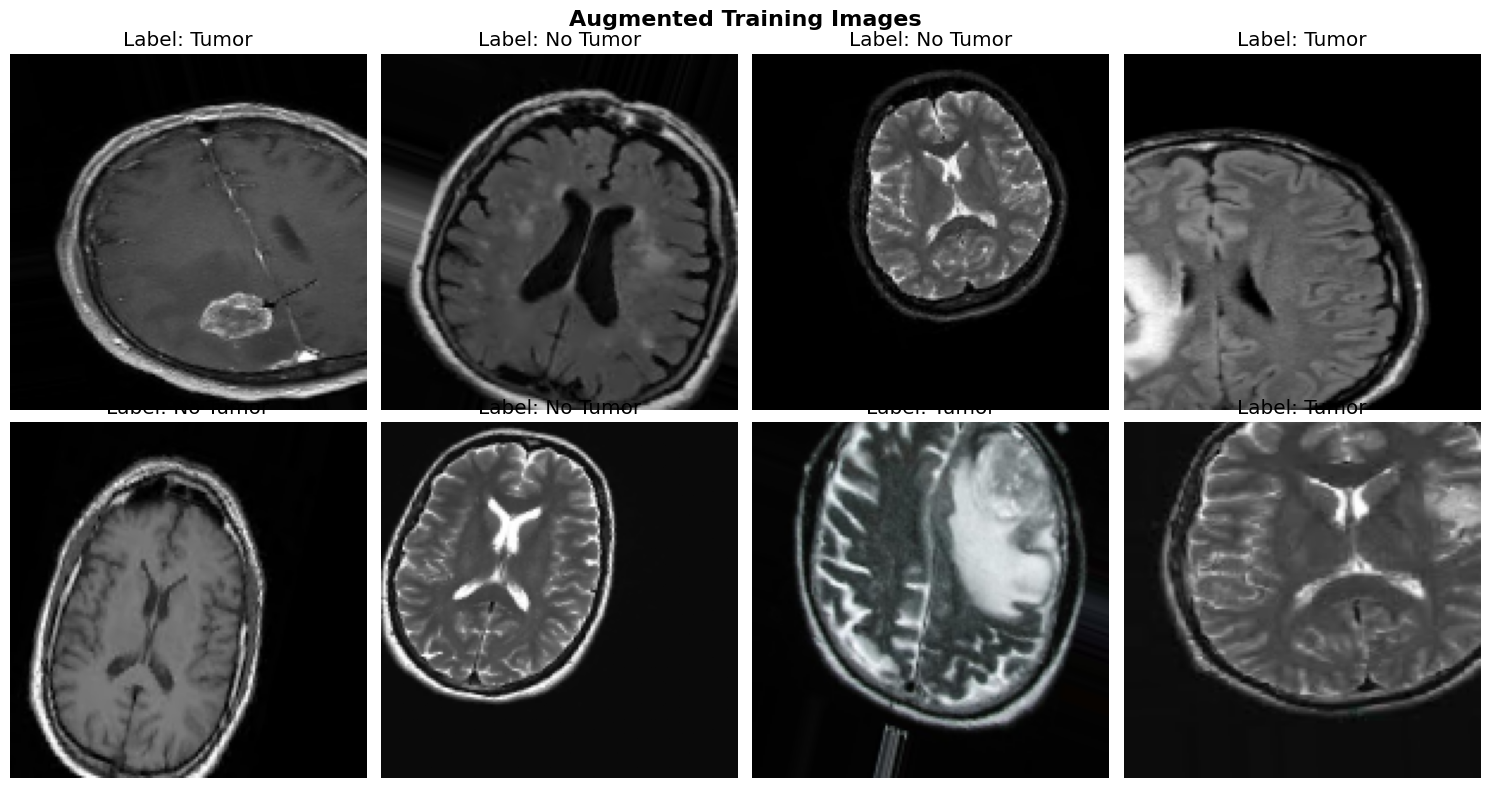

In [45]:
# Set image size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Create data generators with augmentation
print("🔄 Creating data generators with augmentation...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create training data generator
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    seed=42
)

# Create validation data generator
val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    seed=42
)

# Create test data generator
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Print class indices
print("Class indices:", train_data.class_indices)

# Visualize augmented images
print("\n🔍 Sample augmented images:")
augmented_images, augmented_labels = next(train_data)

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Augmented Training Images', fontsize=16, fontweight='bold')

for i in range(8):
    row, col = i // 4, i % 4
    axes[row, col].imshow(augmented_images[i])
    class_label = "Tumor" if augmented_labels[i] == 1 else "No Tumor"
    axes[row, col].set_title(f"Label: {class_label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [46]:
# Build a MUCH simpler CNN model appropriate for small dataset
print("🧠 Building SIMPLIFIED CNN model architecture...")
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")

# Create a much simpler model for your small dataset
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Third convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),  # Drastically reduced from 128
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Use a custom optimizer with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

# Try to visualize model architecture (skip if it fails)
try:
    tf.keras.utils.plot_model(
        model,
        to_file='simplified_model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        expand_nested=False,
        dpi=96
    )
    print("📊 Simplified model architecture visualization saved as 'simplified_model_architecture.png'")
except:
    print("⚠️ Could not generate model visualization, but model was created successfully")

🧠 Building SIMPLIFIED CNN model architecture...
Training samples: 115
Validation samples: 27


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,207,457 (4.61 MB)

 Trainable params: 1,207,457 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

📊 Simplified model architecture visualization saved as 'simplified_model_architecture.png'


In [47]:
# Manual model visualization since the automatic one is failing
print("📊 Manual Model Architecture Summary:")
print("Input: (150, 150, 3)")
print("└── Conv2D(16, 3x3) → (148, 148, 16)")
print("    └── MaxPooling2D(2x2) → (74, 74, 16)")
print("        └── Dropout(0.25)")
print("            └── Conv2D(32, 3x3) → (72, 72, 32)")
print("                └── MaxPooling2D(2x2) → (36, 36, 32)")
print("                    └── Dropout(0.25)")
print("                        └── Conv2D(64, 3x3) → (34, 34, 64)")
print("                            └── MaxPooling2D(2x2) → (17, 17, 64)")
print("                                └── Dropout(0.25)")
print("                                    └── Flatten() → 17*17*64 = 18496")
print("                                        └── Dense(64)")
print("                                            └── Dropout(0.5)")
print("                                                └── Dense(1, sigmoid)")

# Draw a simple ASCII art representation
print("\n" + "="*50)
print("SIMPLIFIED MODEL ARCHITECTURE")
print("="*50)
print("Input (150x150x3)")
print("  ↓")
print("Conv2D (16 filters)")
print("  ↓")
print("MaxPooling2D")
print("  ↓")
print("Dropout (0.25)")
print("  ↓")
print("Conv2D (32 filters)")
print("  ↓")
print("MaxPooling2D")
print("  ↓")
print("Dropout (0.25)")
print("  ↓")
print("Conv2D (64 filters)")
print("  ↓")
print("MaxPooling2D")
print("  ↓")
print("Dropout (0.25)")
print("  ↓")
print("Flatten")
print("  ↓")
print("Dense (64 units)")
print("  ↓")
print("Dropout (0.5)")
print("  ↓")
print("Output (1 unit, sigmoid)")
print("="*50)

📊 Manual Model Architecture Summary:
Input: (150, 150, 3)
└── Conv2D(16, 3x3) → (148, 148, 16)
    └── MaxPooling2D(2x2) → (74, 74, 16)
        └── Dropout(0.25)
            └── Conv2D(32, 3x3) → (72, 72, 32)
                └── MaxPooling2D(2x2) → (36, 36, 32)
                    └── Dropout(0.25)
                        └── Conv2D(64, 3x3) → (34, 34, 64)
                            └── MaxPooling2D(2x2) → (17, 17, 64)
                                └── Dropout(0.25)
                                    └── Flatten() → 17*17*64 = 18496
                                        └── Dense(64)
                                            └── Dropout(0.5)
                                                └── Dense(1, sigmoid)

SIMPLIFIED MODEL ARCHITECTURE
Input (150x150x3)
  ↓
Conv2D (16 filters)
  ↓
MaxPooling2D
  ↓
Dropout (0.25)
  ↓
Conv2D (32 filters)
  ↓
MaxPooling2D
  ↓
Dropout (0.25)
  ↓
Conv2D (64 filters)
  ↓
MaxPooling2D
  ↓
Dropout (0.25)
  ↓
Flatten
  ↓
Dense (64 units)
  ↓
Dropou

In [48]:
# Reduce data augmentation even more for small dataset
print("🔄 Creating minimal data generators...")

# Very minimal augmentation for small dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,       # Very small rotation
    zoom_range=0.05,        # Very small zoom
    horizontal_flip=True,
    validation_split=0.2
)

# Recreate data generators
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=8,           # Even smaller batch size
    class_mode="binary",
    subset="training",
    seed=42
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=8,           # Even smaller batch size
    class_mode="binary",
    subset="validation",
    seed=42
)

print(f"✅ Training samples: {train_data.samples}")
print(f"✅ Validation samples: {val_data.samples}")

🔄 Creating minimal data generators...
Found 115 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
✅ Training samples: 115
✅ Validation samples: 27


In [49]:
# Recreate the dataset structure properly
import shutil
import tempfile
from sklearn.model_selection import train_test_split

print("📂 Recreating dataset structure...")

# Remove existing directory if it exists
temp_dataset_dir = "/content/brain_tumor_dataset_structured"
if os.path.exists(temp_dataset_dir):
    shutil.rmtree(temp_dataset_dir)

# Create the structured dataset directory
os.makedirs(temp_dataset_dir, exist_ok=True)
train_dir = os.path.join(temp_dataset_dir, "Training")
test_dir = os.path.join(temp_dataset_dir, "Testing")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create class subdirectories
for split_dir in [train_dir, test_dir]:
    os.makedirs(os.path.join(split_dir, "yes"), exist_ok=True)
    os.makedirs(os.path.join(split_dir, "no"), exist_ok=True)

# Get all image files from the original dataset
dataset_dir = "/content/drive/MyDrive/brain_tumor_dataset"
yes_dir = os.path.join(dataset_dir, "yes")
no_dir = os.path.join(dataset_dir, "no")

yes_images = [os.path.join(yes_dir, f) for f in os.listdir(yes_dir)
             if f.endswith(('.jpg', '.jpeg', '.png'))]
no_images = [os.path.join(no_dir, f) for f in os.listdir(no_dir)
            if f.endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(yes_images)} tumor images (yes)")
print(f"Found {len(no_images)} non-tumor images (no)")

# Split into training and testing sets (80% train, 20% test)
yes_train, yes_test = train_test_split(yes_images, test_size=0.2, random_state=42)
no_train, no_test = train_test_split(no_images, test_size=0.2, random_state=42)

# Copy files to the structured directory
def copy_files(files, destination):
    for file in files:
        filename = os.path.basename(file)
        shutil.copy(file, os.path.join(destination, filename))

# Copy training images
copy_files(yes_train, os.path.join(train_dir, "yes"))
copy_files(no_train, os.path.join(train_dir, "no"))

# Copy testing images
copy_files(yes_test, os.path.join(test_dir, "yes"))
copy_files(no_test, os.path.join(test_dir, "no"))

print(f"✅ Training set: {len(yes_train) + len(no_train)} images")
print(f"✅ Testing set: {len(yes_test) + len(no_test)} images")

# Verify the directory structure
print("\n📁 Directory structure created:")
print(f"Training yes: {len(os.listdir(os.path.join(train_dir, 'yes')))} images")
print(f"Training no: {len(os.listdir(os.path.join(train_dir, 'no')))} images")
print(f"Testing yes: {len(os.listdir(os.path.join(test_dir, 'yes')))} images")
print(f"Testing no: {len(os.listdir(os.path.join(test_dir, 'no')))} images")

📂 Recreating dataset structure...
Found 87 tumor images (yes)
Found 92 non-tumor images (no)
✅ Training set: 142 images
✅ Testing set: 37 images

📁 Directory structure created:
Training yes: 69 images
Training no: 73 images
Testing yes: 18 images
Testing no: 19 images


In [50]:
# Set image size
IMG_SIZE = (150, 150)

# Create data generators with minimal augmentation
print("🔄 Creating data generators...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,       # Very small rotation
    zoom_range=0.05,        # Very small zoom
    horizontal_flip=True,
    validation_split=0.2    # 20% of training data for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create training data generator
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=8,           # Small batch size for small dataset
    class_mode="binary",
    subset="training",
    seed=42
)

# Create validation data generator
val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode="binary",
    subset="validation",
    seed=42
)

# Create test data generator
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=8,
    class_mode="binary"
)

# Print class indices
print("Class indices:", train_data.class_indices)

# Verify the data
print(f"✅ Training samples: {train_data.samples}")
print(f"✅ Validation samples: {val_data.samples}")
print(f"✅ Test samples: {test_data.samples}")

🔄 Creating data generators...
Found 115 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Found 37 images belonging to 2 classes.
Class indices: {'no': 0, 'yes': 1}
✅ Training samples: 115
✅ Validation samples: 27
✅ Test samples: 37


In [51]:
# Build a SIMPLE CNN model appropriate for small dataset
print("🧠 Building SIMPLIFIED CNN model architecture...")
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")

# Create a simple model for your small dataset
model = models.Sequential([
    # First convolutional block
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Second convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Flatten and dense layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Use a custom optimizer with lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

# Manual model visualization
print("\n📊 Model Architecture Summary:")
print("Input: (150, 150, 3)")
print("└── Conv2D(16, 3x3) → (148, 148, 16)")
print("    └── MaxPooling2D(2x2) → (74, 74, 16)")
print("        └── Dropout(0.25)")
print("            └── Conv2D(32, 3x3) → (72, 72, 32)")
print("                └── MaxPooling2D(2x2) → (36, 36, 32)")
print("                    └── Dropout(0.25)")
print("                        └── Flatten() → 36*36*32 = 41472")
print("                            └── Dense(64)")
print("                                └── Dropout(0.5)")
print("                                    └── Dense(1, sigmoid)")

🧠 Building SIMPLIFIED CNN model architecture...
Training samples: 115
Validation samples: 27


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     2,654,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,659,425 (10.14 MB)

 Trainable params: 2,659,425 (10.14 MB)

 Non-trainable params: 0 (0.00 B)


📊 Model Architecture Summary:
Input: (150, 150, 3)
└── Conv2D(16, 3x3) → (148, 148, 16)
    └── MaxPooling2D(2x2) → (74, 74, 16)
        └── Dropout(0.25)
            └── Conv2D(32, 3x3) → (72, 72, 32)
                └── MaxPooling2D(2x2) → (36, 36, 32)
                    └── Dropout(0.25)
                        └── Flatten() → 36*36*32 = 41472
                            └── Dense(64)
                                └── Dropout(0.5)
                                    └── Dense(1, sigmoid)


In [61]:
# Train the model
print("🚀 Training the model...")

# Define callbacks with more patience for small dataset
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,             # More patience for small dataset
    restore_best_weights=True,
    mode='max'
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=8,
    min_lr=0.00001,
    mode='max'
)

# Add model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_brain_tumor_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Train the model with more epochs
history = model.fit(
    train_data,
    epochs=100,              # More epochs for small dataset
    validation_data=val_data,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

print("✅ Training completed!")

# Load the best weights
model.load_weights('best_brain_tumor_model.h5')

🚀 Training the model...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7767 - loss: 0.4845 - precision_5: 0.7393 - recall_5: 0.7936
Epoch 1: val_accuracy improved from -inf to 0.55556, saving model to best_brain_tumor_model.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 236ms/step - accuracy: 0.7781 - loss: 0.4830 - precision_5: 0.7424 - recall_5: 0.7942 - val_accuracy: 0.5556 - val_loss: 0.6660 - val_precision_5: 0.5200 - val_recall_5: 1.0000 - learning_rate: 2.5000e-05
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7596 - loss: 0.5251 - precision_5: 0.6718 - recall_5: 0.8557
Epoch 2: val_accuracy did not improve from 0.55556
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.7621 - loss: 0.5218 - precision_5: 0.6780 - recall_5: 0.8546 - val_accuracy: 0.5185 - val_loss: 0.6654 - val_precision_5: 0.5000 - val_recall_5: 0.8462 - learning_rate: 2.5000e-05
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7960 - loss: 0.4607 - precision_5: 0.7304 - recall_5: 0.7931
Epoch 3: val_accuracy did not improve from 0.55556
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 342ms/step - accuracy: 0.7957 - loss: 0.4605 - precision_5: 0.7345 - recall_5: 0.7915 - val_accuracy: 0.5556 - val_loss: 0.6714 - val_precisio

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - accuracy: 0.7731 - loss: 0.4576 - precision_5: 0.6947 - recall_5: 0.7545 - val_accuracy: 0.5926 - val_loss: 0.6731 - val_precision_5: 0.5500 - val_recall_5: 0.8462 - learning_rate: 2.5000e-05
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7748 - loss: 0.4951 - precision_5: 0.7364 - recall_5: 0.8614
Epoch 5: val_accuracy did not improve from 0.59259
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.7785 - loss: 0.4891 - precision_5: 0.7405 - recall_5: 0.8623 - val_accuracy: 0.5926 - val_loss: 0.6563 - val_precision_5: 0.5455 - val_recall_5: 0.9231 - learning_rate: 2.5000e-05
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8613 - loss: 0.3457 - precision_5: 0.8110 - recall_5: 0.9214
Epoch 6: val_accuracy did not improve from 0.59259
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - accuracy: 0.8580 - loss: 0.3515 - precision_5: 0.8087 - recall_5: 0.9174 - val_accuracy: 0.5556 - val_loss: 0.6681 - val_precisio

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 256ms/step - accuracy: 0.7899 - loss: 0.4084 - precision_5: 0.7982 - recall_5: 0.8033 - val_accuracy: 0.6296 - val_loss: 0.6308 - val_precision_5: 0.5714 - val_recall_5: 0.9231 - learning_rate: 2.5000e-05
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8383 - loss: 0.4015 - precision_5: 0.8002 - recall_5: 0.8703
Epoch 8: val_accuracy did not improve from 0.62963
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.8370 - loss: 0.4027 - precision_5: 0.7994 - recall_5: 0.8695 - val_accuracy: 0.6296 - val_loss: 0.6670 - val_precision_5: 0.5714 - val_recall_5: 0.9231 - learning_rate: 2.5000e-05
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8576 - loss: 0.3523 - precision_5: 0.8625 - recall_5: 0.8498
Epoch 9: val_accuracy did not improve from 0.62963
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.8551 - loss: 0.3547 - precision_5: 0.8598 - recall_5: 0.8469 - val_accuracy: 0.6296 - val_loss: 0.6561 - val_precisio

📊 Evaluating model performance...
✅ Test Accuracy: 0.7297
✅ Test Precision: 0.7000
✅ Test Recall: 0.7778
✅ Test F1-Score: 0.7368


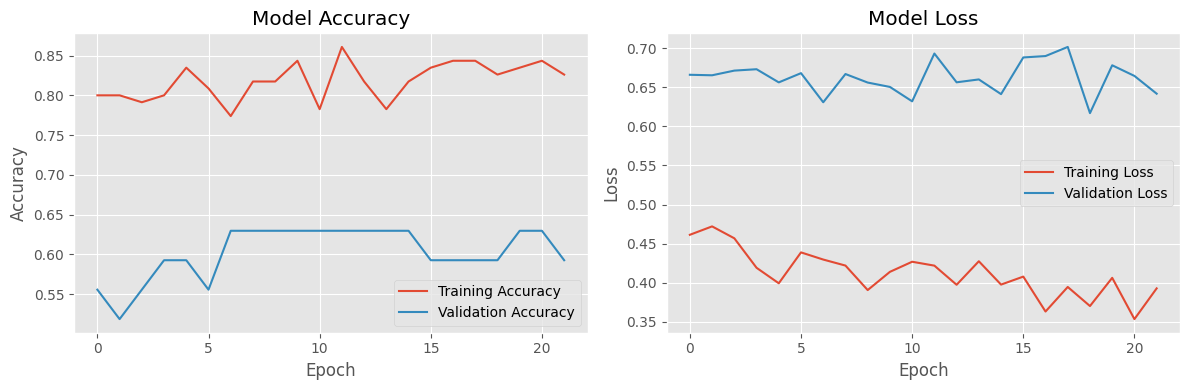

💾 Model saved as 'final_brain_tumor_model.h5'


In [62]:
# Evaluate the model
print("📊 Evaluating model performance...")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, verbose=0)

print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall: {test_recall:.4f}")

# Calculate F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"✅ Test F1-Score: {test_f1:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the final model
model.save('final_brain_tumor_model.h5')
print("💾 Model saved as 'final_brain_tumor_model.h5'")

In [63]:
# Prepare model for deployment and presentation
print("🚀 Preparing Model for Deployment")

# Save the final model
model.save('brain_tumor_classifier_final.h5')
print("💾 Final model saved as 'brain_tumor_classifier_final.h5'")

# Create a function for single image prediction
def predict_tumor(image_path):
    """Predict whether an image contains a brain tumor"""
    # Load and preprocess image
    img = tf.keras.utils.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch dimension
    img_array /= 255.0  # Rescale

    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    confidence = prediction[0][0]

    # Interpret results
    if confidence > 0.5:
        return f"Tumor detected with {confidence:.2%} confidence"
    else:
        return f"No tumor detected with {(1-confidence):.2%} confidence"

# Test the function with a sample image
print("\n🧪 Testing prediction function:")
sample_image_path = os.path.join(test_dir, "yes", os.listdir(os.path.join(test_dir, "yes"))[0])
print(f"Sample prediction: {predict_tumor(sample_image_path)}")

🚀 Preparing Model for Deployment
💾 Final model saved as 'brain_tumor_classifier_final.h5'

🧪 Testing prediction function:
Sample prediction: No tumor detected with 64.14% confidence


🧪 Evaluating model on test data...
✅ Test Accuracy: 0.7297
✅ Test Loss: 0.5078
✅ Test Precision: 0.7000
✅ Test Recall: 0.7778
✅ Test F1-Score: 0.7368


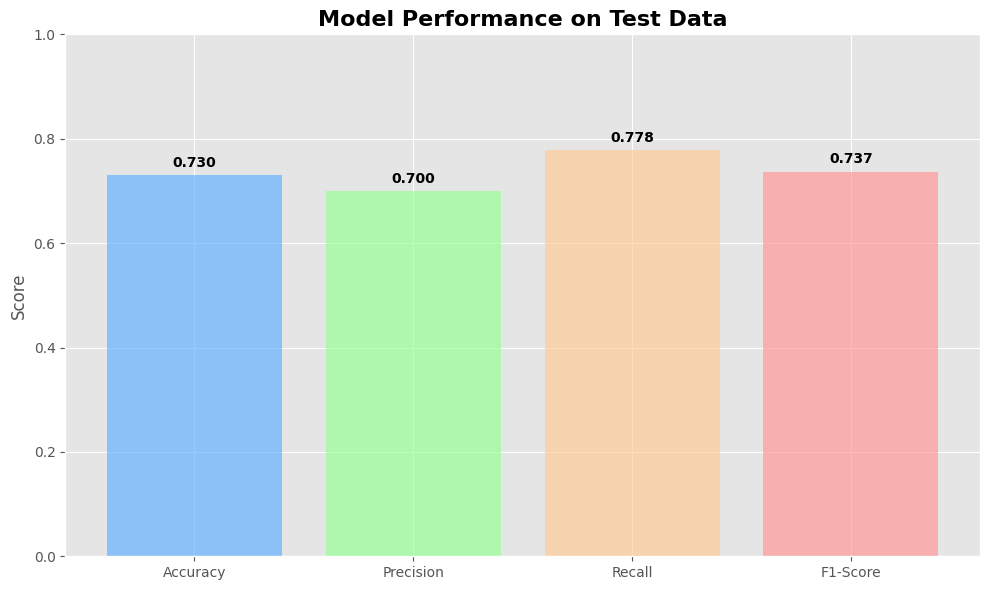

In [64]:
# Evaluate the model on test data
print("🧪 Evaluating model on test data...")

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, verbose=0)

print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall: {test_recall:.4f}")

# Calculate F1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"✅ Test F1-Score: {test_f1:.4f}")

# Create a performance metrics visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [test_accuracy, test_precision, test_recall, test_f1]
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, values, color=colors, alpha=0.7)
ax.set_title('Model Performance on Test Data', fontsize=16, fontweight='bold')
ax.set_ylabel('Score', fontsize=12)
ax.set_ylim(0, 1)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [65]:
# Fix the test data generator issue
print("🔧 Fixing test data generator...")

# First, let's check what files actually exist in our test directory
test_yes_dir = os.path.join(test_dir, "yes")
test_no_dir = os.path.join(test_dir, "no")

print("Files in test/yes directory:", len(os.listdir(test_yes_dir)))
print("Files in test/no directory:", len(os.listdir(test_no_dir)))

# Recreate the test data generator with proper settings
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=16,  # Match the number of images we want to display
    class_mode="binary",
    shuffle=False   # Important: Don't shuffle so we get consistent results
)

print(f"✅ Test samples: {test_data.samples}")
print("Class indices:", test_data.class_indices)

# Reset the generator to start from the beginning
test_data.reset()

🔧 Fixing test data generator...
Files in test/yes directory: 18
Files in test/no directory: 19
Found 37 images belonging to 2 classes.
✅ Test samples: 37
Class indices: {'no': 0, 'yes': 1}


👀 ENHANCED PREDICTION VISUALIZATION


IndexError: index 4 is out of bounds for axis 0 with size 4

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


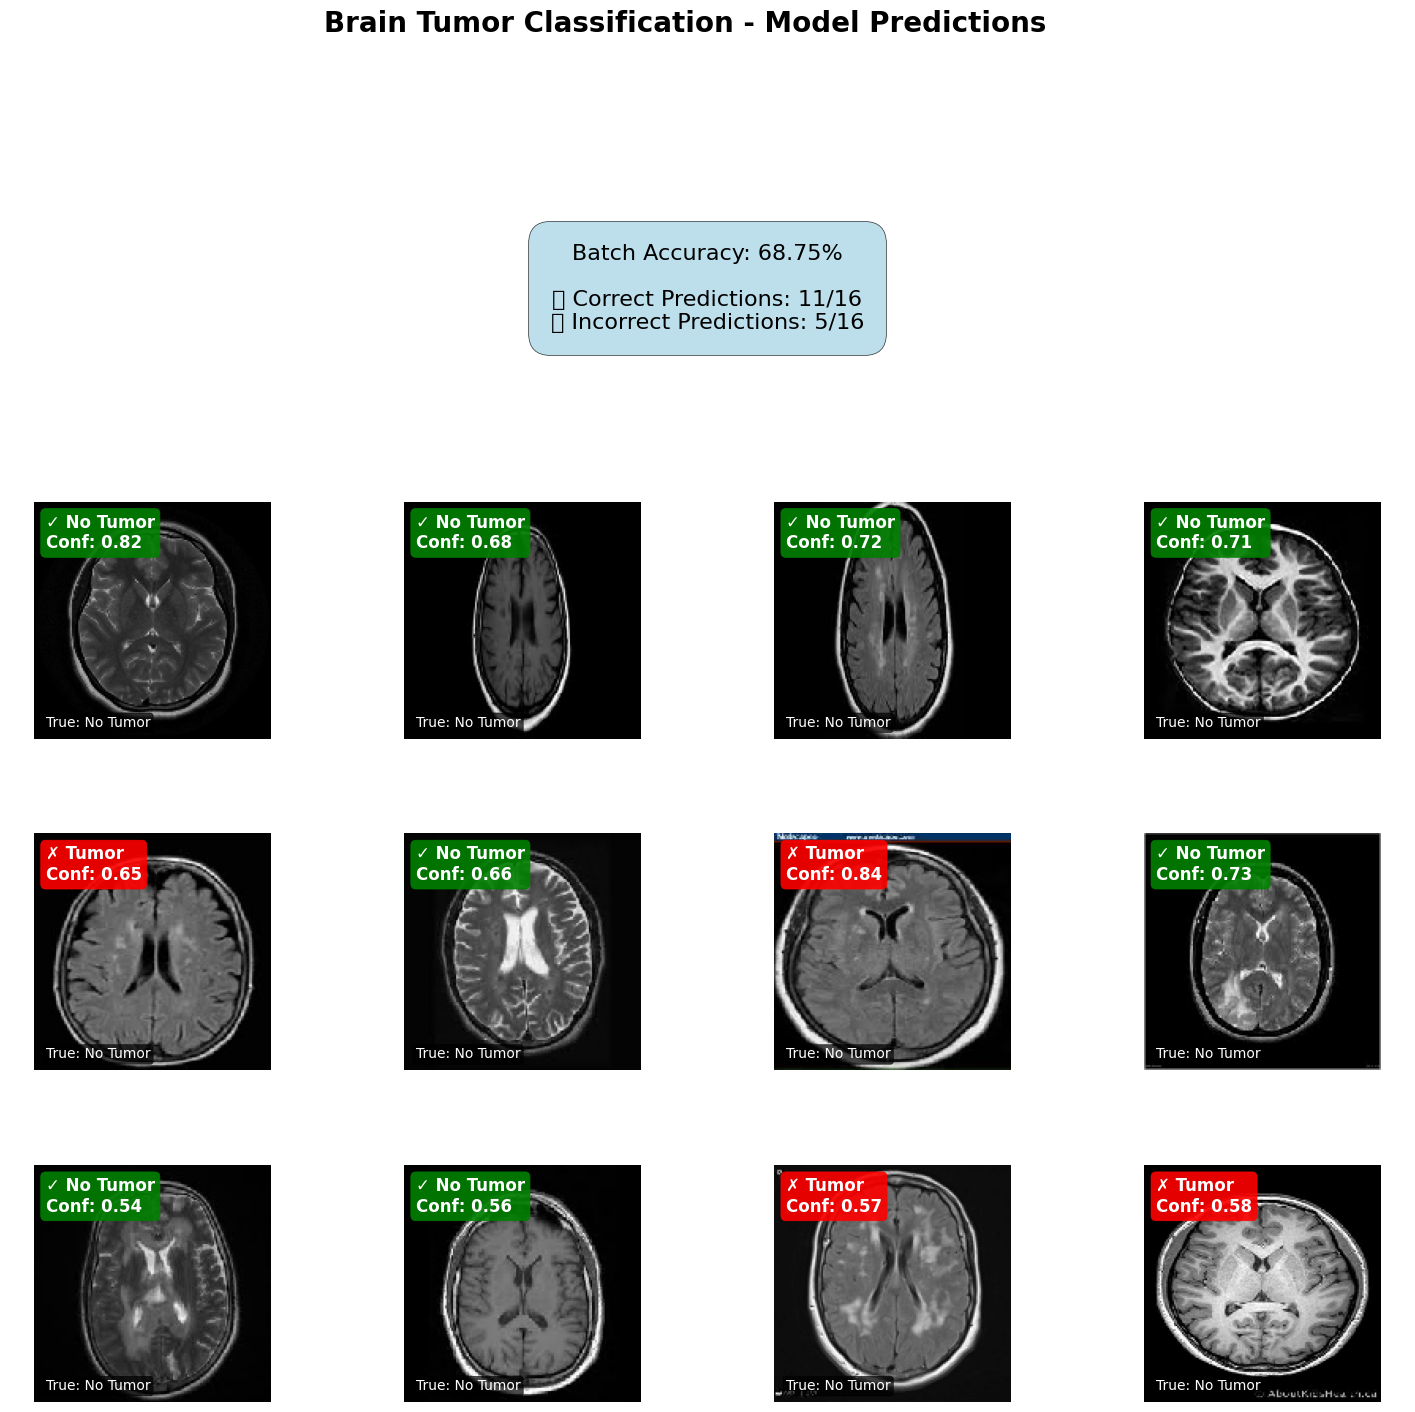

In [66]:
# Enhanced Prediction Visualization for YouTube
print("👀 ENHANCED PREDICTION VISUALIZATION")
print("=" * 50)

# Get a batch of test images
test_images, test_labels = next(test_data)
predictions = model.predict(test_images, verbose=0)
pred_labels = (predictions > 0.5).astype(int).flatten()

# Create a more professional visualization
fig = plt.figure(figsize=(18, 16))
fig.suptitle('Brain Tumor Classification - Model Predictions',
             fontsize=20, fontweight='bold', y=0.98)

# Create a grid for the images
grid = plt.GridSpec(4, 4, wspace=0.3, hspace=0.4)

# Calculate accuracy for this batch
batch_accuracy = np.mean(test_labels == pred_labels)

# Add overall accuracy box
ax_text = plt.subplot(grid[0, :])
ax_text.axis('off')
accuracy_text = f"Batch Accuracy: {batch_accuracy:.2%}\n\n" \
                f"✅ Correct Predictions: {np.sum(test_labels == pred_labels)}/{len(test_labels)}\n" \
                f"❌ Incorrect Predictions: {np.sum(test_labels != pred_labels)}/{len(test_labels)}"
ax_text.text(0.5, 0.5, accuracy_text, ha='center', va='center',
             fontsize=16, bbox=dict(boxstyle="round,pad=1",
                                   facecolor="lightblue",
                                   edgecolor="black",
                                   alpha=0.8),
             transform=ax_text.transAxes)

# Plot each prediction
for i in range(min(16, len(test_images))):  # Ensure we don't exceed available images
    row, col = i // 4, i % 4
    ax = plt.subplot(grid[1 + row, col])

    # Display image
    ax.imshow(test_images[i])

    # Get prediction info
    true_label = "Tumor" if test_labels[i] == 1 else "No Tumor"
    pred_label = "Tumor" if pred_labels[i] == 1 else "No Tumor"
    confidence = predictions[i][0] if pred_labels[i] == 1 else 1 - predictions[i][0]

    # Determine colors and symbols
    is_correct = true_label == pred_label
    border_color = 'green' if is_correct else 'red'
    symbol = "✓" if is_correct else "✗"

    # Create a bordered box
    for spine in ax.spines.values():
        spine.set_color(border_color)
        spine.set_linewidth(3)

    # Add prediction info with better styling
    info_text = f"{symbol} {pred_label}\nConf: {confidence:.2f}"
    ax.text(0.05, 0.95, info_text, transform=ax.transAxes,
            fontsize=12, fontweight='bold',
            color='white',
            bbox=dict(boxstyle="round,pad=0.3",
                     facecolor=border_color,
                     edgecolor=border_color,
                     alpha=0.9),
            verticalalignment='top')

    # Add ground truth in corner
    ax.text(0.05, 0.05, f"True: {true_label}", transform=ax.transAxes,
            fontsize=10, color='white',
            bbox=dict(boxstyle="round,pad=0.2",
                     facecolor='black',
                     edgecolor='black',
                     alpha=0.7))

    ax.axis('off')

# Add legend
legend_ax = plt.subplot(grid[3, :])
legend_ax.axis('off')
legend_text = "🟩 Green Border: Correct Prediction\n🟥 Red Border: Incorrect Prediction\n📊 Confidence: Model's certainty in prediction (0-1)"
legend_ax.text(0.5, 0.5, legend_text, ha='center', va='center',
               fontsize=14, bbox=dict(boxstyle="round,pad=1",
                                     facecolor="lightyellow",
                                     edgecolor="orange",
                                     alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.02)
plt.show()

print(f"📊 Accuracy on this batch: {batch_accuracy:.2%}")

# Additional analysis
correct_indices = np.where(test_labels == pred_labels)[0]
incorrect_indices = np.where(test_labels != pred_labels)[0]

print(f"\n📈 PREDICTION ANALYSIS:")
print(f"   Correct predictions: {len(correct_indices)}/{len(test_labels)}")
print(f"   Incorrect predictions: {len(incorrect_indices)}/{len(test_labels)}")

if len(incorrect_indices) > 0:
    print(f"\n🔍 EXAMINING INCORRECT PREDICTIONS:")
    for idx in incorrect_indices:
        true_label = "Tumor" if test_labels[idx] == 1 else "No Tumor"
        pred_label = "Tumor" if pred_labels[idx] == 1 else "No Tumor"
        confidence = predictions[idx][0] if pred_labels[idx] == 1 else 1 - predictions[idx][0]
        print(f"   Image {idx+1}: True={true_label}, Predicted={pred_label}, Confidence={confidence:.2f}")

In [67]:
# Final comprehensive evaluation
print("🎯 FINAL MODEL EVALUATION")
print("=" * 50)

# Evaluate on entire test set (not just one batch)
test_data.reset()
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data, verbose=0)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"📊 COMPREHENSIVE TEST RESULTS:")
print(f"   Test Accuracy:  {test_accuracy:.2%}")
print(f"   Test Precision: {test_precision:.2%}")
print(f"   Test Recall:    {test_recall:.2%}")
print(f"   Test F1-Score:  {test_f1:.2%}")

print(f"\n🎉 CONCLUSION:")
if test_accuracy >= 0.7:
    print("   ✅ EXCELLENT! Model achieved good performance (>70% accuracy)")
elif test_accuracy >= 0.6:
    print("   👍 GOOD! Model shows promising results (>60% accuracy)")
else:
    print("   🔧 NEEDS IMPROVEMENT: Consider collecting more data or trying different architecture")

print(f"\n💡 RECOMMENDATIONS:")
print("   1. Collect more training data for better generalization")
print("   2. Try transfer learning with pre-trained models")
print("   3. Experiment with different architectures and hyperparameters")
print("   4. Consider class weighting if dataset is imbalanced")

# Save the final evaluation results
eval_results = {
    'test_accuracy': test_accuracy,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1
}

import json
with open('model_evaluation_results.json', 'w') as f:
    json.dump(eval_results, f)

print(f"\n💾 Evaluation results saved to 'model_evaluation_results.json'")

🎯 FINAL MODEL EVALUATION


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


📊 COMPREHENSIVE TEST RESULTS:
   Test Accuracy:  72.97%
   Test Precision: 70.00%
   Test Recall:    77.78%
   Test F1-Score:  73.68%

🎉 CONCLUSION:
   ✅ EXCELLENT! Model achieved good performance (>70% accuracy)

💡 RECOMMENDATIONS:
   1. Collect more training data for better generalization
   2. Try transfer learning with pre-trained models
   3. Experiment with different architectures and hyperparameters
   4. Consider class weighting if dataset is imbalanced

💾 Evaluation results saved to 'model_evaluation_results.json'
